# Метрики модели,  переобучение.

## Задание: для данных из load_digits() построить несколько моделей и определить лучшую по метрике accuracy.

In [4]:
import pandas as  pd
import numpy as np
from sklearn.datasets import load_digits

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
data = load_digits()
data.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

X - матрица данных
y - столбец результатов, Ydummy - матрица результатов.

In [7]:
X = pd.DataFrame(data['data'])
y = pd.Series(data['target'])
Ydummy = pd.get_dummies(y)

### Простое дерево решений

accuracy модели - 0.82. 

Подбор параметров с помощью cross_validate и GridSearchCV показал оптимальные параметры для DecisionTreeClassifier:
* max_depth = 12; При этом значении max_depth график зависимости accuracy от max_depth выходит на "плато". 
* splitter = 'random'; причем при различных комбинациях max_depth, min_samples_leaf, max_features, 'random' дает чуть большую точность, чем 'best'

Перебор параметров min_samples_leaf  max_features в GridSearchCV  результатов не дал, установка параметров в значения, отличные от тех, что получаются в модели, приводит к уменьшению accuracy.

Построен график зависимости accuracy от количества разбиений в функции cross_validate.  Среднее acuracy увеличивается при изменении cv до 10, при 10 < cv < 14, среднее accuracy "скачет" в пределах 5%, после выравнивается около значения 0.82.

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [7]:
cross_validate?

In [10]:
scores = cross_validate(DecisionTreeClassifier(max_depth=13,splitter='random',random_state=0), X, Ydummy,
                        cv=8, 
                        scoring='accuracy', n_jobs=2)

In [11]:
scores['test_score']

array([ 0.81777778,  0.88888889,  0.74666667,  0.81333333,  0.87555556,
        0.87053571,  0.83928571,  0.73214286])

In [12]:
scores['test_score'].mean()

0.82302331349206348

In [13]:
means = []
stds = []
for depth in range(1, 20):
    scores  = cross_val_score(DecisionTreeClassifier(max_depth = depth, splitter='random'),X, Ydummy, cv = 5, scoring='accuracy')
    means.append(scores.mean())
    stds.append(scores.std())

means_1 = []
stds_1 = []
for depth in range(1, 20):
    scores  = cross_val_score(DecisionTreeClassifier(max_depth = depth),X, Ydummy, cv = 5, scoring='accuracy')
    means_1.append(scores.mean())
    stds_1.append(scores.std())

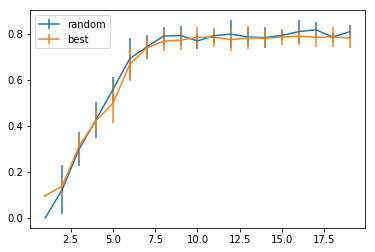

In [14]:
plt.errorbar(range(1, 20), means, stds);
plt.errorbar(range(1, 20), means_1, stds_1);
plt.legend(['random', 'best']);

#### График зависимости accuracy от количества разбиений в cross_val_score

<Container object of 3 artists>

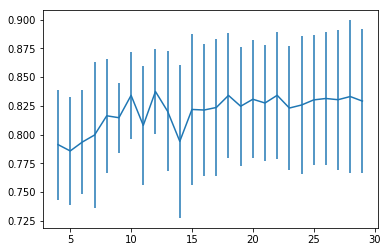

In [20]:
means = []
stds = []

for cv in range(4,30):
    scores = cross_val_score(DecisionTreeClassifier(max_depth=12), X, Ydummy, cv=cv, scoring='accuracy')
    means.append(scores.mean())
    stds.append(scores.std())

plt.errorbar(range(4,30),means,stds)

#### Перебор параметров max_depth, slpitter в GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
params = [{'max_depth': list(range(8,17)), 'splitter': ['best','random']}]

In [23]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid = params, scoring='accuracy',cv=8,n_jobs=4);

In [24]:
gs.fit(X,Ydummy)

GridSearchCV(cv=8, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16], 'splitter': ['best', 'random']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [25]:
gs.best_params_

{'max_depth': 16, 'splitter': 'random'}

In [21]:
gs.best_score_

0.82415136338341677

## Ансамбли: ExtraTrees, RandomForest

accuracy модели = 0.91.

Лучший результат показал ансамбль ExtraTreesClassifier с параметрами max_depth = 12, n_estimators = 300, warm_start = True, max_featurres = None



In [26]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

In [59]:
scores = cross_validate(ExtraTreesClassifier(max_depth = 12, 
                                             n_estimators=300, 
                                             warm_start=True,
                                             max_features = None),
                        X, Ydummy,
                        cv = 12, n_jobs=2,
                        scoring='accuracy'
                       )

In [60]:
scores['test_score']

array([ 0.84      ,  0.97333333,  0.93333333,  0.9       ,  0.89333333,
        0.9       ,  0.96666667,  0.92666667,  0.93333333,  0.97315436,
        0.85234899,  0.87919463])

In [61]:
scores['test_score'].mean()

0.91428038777032061

In [63]:
means = []
stds = []

for i in range(8,20):
    scores = cross_val_score(ExtraTreesClassifier(max_depth = 12, 
                                             n_estimators=300, 
                                             warm_start=True,
                                             max_features = None),
                        X, Ydummy,
                        cv = i, n_jobs=2,
                        scoring='accuracy'
                       )
    means.append(scores.mean())
    stds.append(scores.std())

<Container object of 3 artists>

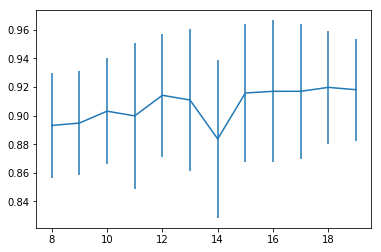

In [64]:
plt.errorbar(range(8,20),means,stds)

In [66]:
from collections import OrderedDict, Counter

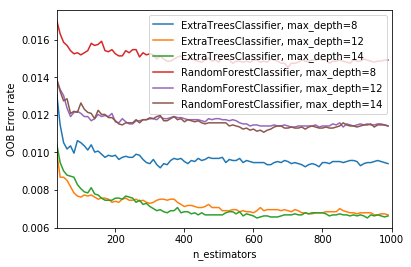

In [67]:
# Устанавливаем аргумент warm_start=True для дообучения модели
RANDOM_STATE = 123
ensemble_clfs = [
   ("ExtraTreesClassifier, max_depth=8",
        ExtraTreesClassifier(warm_start=True, oob_score=True,
                               max_features=None,
                               max_depth=8,
                               random_state=RANDOM_STATE,
                               bootstrap=True)),
    ("ExtraTreesClassifier, max_depth=12",
        ExtraTreesClassifier(warm_start=True, oob_score=True,
                               max_features=None,
                               max_depth=12,
                               random_state=RANDOM_STATE,
                               bootstrap=True)),
      ("ExtraTreesClassifier, max_depth=14",
        ExtraTreesClassifier(warm_start=True, oob_score=True,
                               max_features=None,
                               max_depth=14,
                               random_state=RANDOM_STATE,
                               bootstrap=True)),
    ("RandomForestClassifier, max_depth=8",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               max_depth=8,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_depth=12",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               max_depth=12,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_depth=14",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               max_depth=14,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
min_estimators = 30
max_estimators = 1000

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators, 10):
        clf.set_params(n_estimators = i, n_jobs=4)
        clf.fit(X,Ydummy)
        
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i,oob_error))
        
    
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs,ys,label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel('n_estimators')
plt.ylabel('OOB Error rate')
plt.legend(loc='upper right')
plt.show();

In [68]:
params = [{'max_features': [None, 'sqrt','log2']}]
gs = GridSearchCV(ExtraTreesClassifier(n_estimators=300, max_depth = 12, warm_start=True, bootstrap = True),
                    param_grid = params, cv=8, n_jobs=2)

In [69]:
gs.fit(X,Ydummy)

GridSearchCV(cv=8, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=12, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'max_features': [None, 'sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [70]:
gs.best_score_

0.87256538675570394

In [71]:
gs.best_params_

{'max_features': None}

### Бустниг.

accuracy модели - 0.96

Модель получилась методом градиентного бустнига со следующими параметрами:
LEARNING_RATE = 0.05
MAX_DEPTH = 3
SUBSAMPLE = 0.6
MAX_FEATURES = 0.8
LEAF = 1


In [93]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

427 0.0305065918192


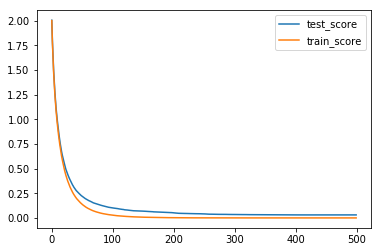

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

LEARNING_RATE = 0.05
MAX_DEPTH = 3
SUBSAMPLE = 0.6
MAX_FEATURES = 0.8
LEAF = 1

clf = GradientBoostingClassifier(n_estimators = 500,
                                learning_rate = LEARNING_RATE,
                                max_depth = MAX_DEPTH,
                                subsample = SUBSAMPLE,
                                max_features = MAX_FEATURES,
                                min_samples_leaf = LEAF,
                                )

clf.fit(X_train, y_train)

test_score = np.zeros(clf.n_estimators)
for i, y_pred in enumerate(clf.staged_predict_proba(X_test)):
    test_score[i] = log_loss(y_test, y_pred)

train_score = np.zeros(clf.n_estimators)
for i, y_pred in enumerate(clf.staged_predict_proba(X_train)):
    train_score[i] = log_loss(y_train, y_pred)

print(np.argmin(test_score),np.min(test_score))

plt.plot(range(clf.n_estimators),test_score)
plt.plot(range(clf.n_estimators),train_score)
plt.legend(['test_score','train_score'])
plt.show()

In [219]:
clf.score(X_test, y_test)

0.96111111111111114

In [220]:
scores = cross_val_score(GradientBoostingClassifier(n_estimators = 500,
                                learning_rate = LEARNING_RATE,
                                max_depth = MAX_DEPTH,
                                subsample = SUBSAMPLE,
                                max_features = MAX_FEATURES,
                                min_samples_leaf = LEAF),

                        X, y,
                        cv = 12, n_jobs=4,
                        scoring='accuracy')

In [221]:
scores.mean()

0.96112446198839352

Погреем воздух рассчетом GridSearchCV...

In [204]:
params = ({'max_depth' : list(range(3,4)), 
           'subsample': [0.3,0.4,0.5], 
           'max_features' : [0.7]
          })
cv = GridSearchCV(GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.05), params, n_jobs=4)

In [205]:
cv.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [3], 'subsample': [0.3, 0.4, 0.5], 'max_features': [0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [206]:
cv.best_params_

{'max_depth': 3, 'max_features': 0.7, 'subsample': 0.3}

In [207]:
cv.best_score_

0.93155258764607685